# Memorizing elements of a sequence

The goal of this task is to memorize some specific elements of a sequence a symbols with variable length. This toy example is useful to test the capacity of RNNs to keep representations in memory over long sequences.

In [1]:
%matplotlib inline

## One-hot encoding for string of symbols

In [2]:
# %load binary_code.py
import numpy as np
import matplotlib.pyplot as plt

ALPHABET = np.asarray(list("abcd"), dtype=object)


def symbols_to_binarray(s, alphabet=ALPHABET, dtype=np.float32):
    """One-hot encode a sequence of symbols
    
    This numerical representation of a string of symbols is useful
    to feed the data and expected labels to the input and output
    layers of recurrent networks.
    """
    alphabet = np.asarray(list(alphabet), dtype=object)
    n_samples = len(s)
    n_features = len(alphabet)

    mapping = dict(zip(alphabet, range(n_features)))
    
    code = np.zeros((n_samples, n_features), dtype=dtype)
    for i, e in enumerate(s):
        code[i, mapping[e]] = 1.0
    return code


def binarray_to_symbols(code, alphabet=ALPHABET):
    """Convert encoded data by to a string of symbols"""
    n_samples, n_features = code.shape
    if n_features != len(alphabet):
        raise ValueError(
            "code should have %d columns (instead of %d)."
            % (len(alphabet), n_features)
        )

    # Make sure that the alphabet is a numpy array of symbols
    # to make it possible to leverage numpy fancy indexing
    if not isinstance(alphabet, np.ndarray):
        alphabet = np.asarray(list(alphabet), dtype='object')

    return "".join(alphabet[code.argmax(axis=1)])


def plot_binary_tape(encoded_sequence, alphabet=ALPHABET):
    plt.matshow(encoded_sequence, cmap=plt.cm.gray)
    plt.xticks(np.arange(len(alphabet)), alphabet)
    

def plot_parallel_tapes(input_data, output_data,
                        input_symbols, output_symbols):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 10))
    for ax, data in zip(axes, [input_data, output_data]):
        ax.matshow(data, cmap=plt.cm.gray)
        ax.set_xticks(np.arange(len(ALPHABET)))
        ax.set_xticklabels(ALPHABET, fontsize=18)
    fig.tight_layout()
    plt.title("input: %r, output: %r" % (input_symbols, output_symbols))

In [3]:
symbol_sequence = "abcdacbd"
encoded_sequence = symbols_to_binarray(symbol_sequence)
encoded_sequence

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.]], dtype=float32)

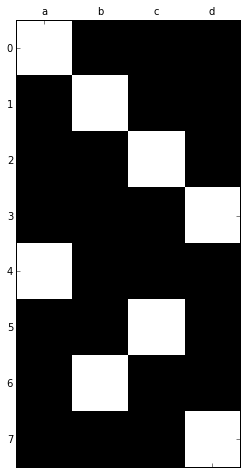

In [4]:
plot_binary_tape(encoded_sequence)

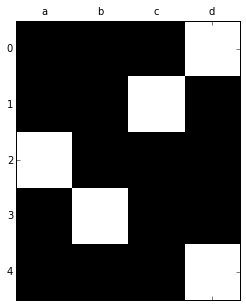

In [5]:
plot_binary_tape(symbols_to_binarray('dcabd'))

## Decoding back to a sequence of symbols

The `binary_to_symbols` function computes the inverse operation:

In [6]:
binarray_to_symbols(encoded_sequence)

'abcdacbd'

## Running count of symbols in a sequence

Let's generate a dataset where the output tape should display the symbol that was the most frequent in the recent history of the input tape (over a fixed window size):

In [7]:
def running_max(encoded_input, window_size=3):
    encoded_output = np.zeros_like(encoded_input)
    for t in range(encoded_input.shape[0]):
        window = encoded_input[t - window_size + 1 :t + 1]
        frequencies = window.sum(axis=0)
        winner = frequencies.argmax()
        encoded_output[t, winner] = 1.
    return encoded_output

Let's run this function on the binary represenation of an example string of symbols:

In [8]:
input_sequence = 'abbaabcddccab'
input_data = symbols_to_binarray(input_sequence)

In [9]:
output_data = running_max(input_data)
output_sequence = binarray_to_symbols(output_data)
print(input_sequence)
print(output_sequence)

abbaabcddccab
aabbaaabddcca


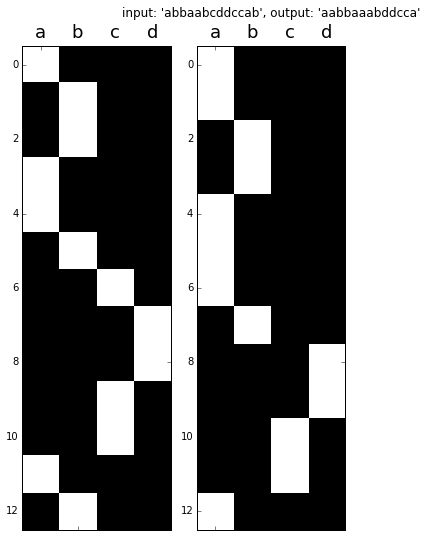

In [10]:
plot_parallel_tapes(input_data, output_data,
                    input_sequence, output_sequence)

This seems to work as expected. Note that in case of tie, 'a' is favored over 'b', 'b' over 'c' and so on. The function to learn is therefore fully deterministic. Let's generate a reference dataset for our RNN experiments.

For let's start with random input sequences:

In [11]:
def generate_sequences(n_sequences=1000, min_length=5, max_length=15,
                       alphabet=ALPHABET, seed=None):
    sequences = []
    rng = np.random.RandomState(seed)
    for i in range(n_sequences):
        length = rng.randint(min_length, max_length)
        sequences.append("".join(rng.choice(ALPHABET, length)))
    return sequences

In [12]:
generate_sequences(n_sequences=5, seed=0)

['addddbdbca', 'caaacbcddcab', 'bbabadadbc', 'cdabd', 'dcdabbbd']

The `seed` parameter makes possible to control the random number generator to get seemingly random yet reproducible deterministic outcomes:

In [13]:
generate_sequences(n_sequences=5, seed=0)

['addddbdbca', 'caaacbcddcab', 'bbabadadbc', 'cdabd', 'dcdabbbd']

In [14]:
generate_sequences(n_sequences=5, seed=1)

['daadbdbdaa', 'adbacb', 'acbcada', 'addbbdc', 'cbbbd']

Now that we have random input sequences, we can compute the expected ouput for each of them and generate a full dataset to train our networks:

In [15]:
def generate_running_max_task_data(n_sequences=1000, min_length=5,
                                   max_length=15, window_size=3,
                                   alphabet=ALPHABET, seed=None):
    
    # Generate the input sequences as symbols
    input_sequences = generate_sequences(
        n_sequences=n_sequences, min_length=min_length,
        max_length=max_length, alphabet=alphabet, seed=seed)
    output_sequences = []

    # Allocate all the data arrays at once and pad with zeros
    n_features = len(alphabet)
    input_data = np.zeros((n_sequences, max_length, n_features),
                          dtype=np.float32)
    output_data = np.zeros((n_sequences, max_length, n_features),
                           dtype=np.float32)
    
    for sequence_idx, input_sequence in enumerate(input_sequences):
        # store the encoded sequence to the input tape
        encoded_input = symbols_to_binarray(input_sequence)
        input_data[sequence_idx, 0:len(input_sequence)] = encoded_input
        encoded_output = running_max(encoded_input,
                                     window_size=window_size)
        output_data[sequence_idx, 0:len(encoded_output)] = encoded_output
        output_sequences.append(binarray_to_symbols(encoded_output))

    return input_sequences, output_sequences, input_data, output_data

Let's try it to generate a toy dataset:

In [16]:
(
    input_sequences,
    output_sequences,
    input_data,
    output_data,
) = generate_memory_task_data(n_sequences=10, seed=0)

NameError: name 'generate_memory_task_data' is not defined

In [ ]:
zip(input_sequences, output_sequences)

In [ ]:
for i in range(3):
    plot_parallel_tapes(input_data[i], output_data[i],
                        input_sequences[i], output_sequences[i])

In [ ]:
input_data.shape

Let's generate some reference data for this task with fixed random seeds to make it possible to compare the results of different study groups on the same data.

We create 2 datasets, one with only short sequences (from 5 to 15 steps in the input sequence) and one with long sequences (from 20 to 50 steps).

In [ ]:
!rm -rf data/running_max_task

In [ ]:
dataset_specs = [
    ('short', dict(min_length=5, max_length=15, window_size=3)),
    ('long', dict(min_length=20, max_length=50, window_size=10)),
]
     
fold_specs = [
    ('train', dict(n_sequences=5000, seed=0)),
    ('validation', dict(n_sequences=1000, seed=1)),
    ('test', dict(n_sequences=1000, seed=2)),
]

data_folder = 'data/running_max'

In [ ]:
import os.path as op
import os
from itertools import product
import pandas as pd


def write_dataset(data_folder, generate_data, dataset_specs, fold_specs):
    if not op.isdir(data_folder):
        os.makedirs(data_folder)

    for combined_specs in product(dataset_specs, fold_specs):
        ds_name, ds_params = combined_specs[0]
        fold_name, fold_params = combined_specs[1]
        params = {}
        params.update(ds_params)
        params.update(fold_params)

        (input_sequences, output_sequences,
         input_data, output_data) = generate_data(**params)

        df = pd.DataFrame({
                'input': input_sequences,
                'output': output_sequences,
        })
        fname = op.join(data_folder, '%s_sequence_%s.json'
                        % (ds_name, fold_name))
        print('Saving symbol sequences %s' % fname)
        df.to_json(fname, orient='records')

        for name, data in (('input', input_data), ('output', output_data)):
            fname = op.join(data_folder, '%s_%s_data_%s.npy'
                            % (ds_name, name, fold_name))
            print('Saving data %s' % fname)
            np.save(fname, data)



write_dataset(data_folder, generate_running_max_task_data,
              dataset_specs, fold_specs)

In [ ]:
short_symbols_train = pd.read_json(
    'data/running_max/short_sequence_train.json')
short_symbols_train.head()

In [ ]:
X_short_train = np.load('data/running_max/short_input_data_train.npy')
Y_short_train = np.load('data/running_max/short_output_data_train.npy')

In [ ]:
for i in range(3):
    plot_parallel_tapes(X_short_train[i], Y_short_train[i],
                        short_symbols_train['input'][i],
                        short_symbols_train['output'][i])

## Generating data for a simple memory task

The goal of this task is to output the 2nd and 5th element of random input sequences.

To solve it, the RNN has to rember the current position (count the element of the sequence) and store some representation of the 2nd and 5th element in its recurrent layer activations.  This task can be made artificially hard by increasing the average lentgh of the sequences as it is likely to be harder to memorize old events.

In [ ]:
generate_sequences(n_sequences=5, min_length=5, max_length=15, seed=0)

Let's generate the sequences as a data array padded with zeros.

In [ ]:
def generate_memory_task_data(n_sequences=1000, min_length=5,
                              max_length=15, alphabet=ALPHABET,
                              seed=None):
    
    # Generate the input sequences as symbols
    input_sequences = generate_sequences(
        n_sequences=n_sequences, min_length=min_length,
        max_length=max_length, alphabet=alphabet, seed=seed)
    output_sequences = []
    
    # 2 steps are used for the expected output
    n_steps_per_sequence = (max_length + 2)

    # Allocate all the data arrays at once and pad with zeros
    n_features = len(alphabet)
    input_data = np.zeros((n_sequences, n_steps_per_sequence, n_features),
                          dtype=np.float32)
    output_data = np.zeros((n_sequences, n_steps_per_sequence, n_features),
                           dtype=np.float32)
    
    for sequence_idx, input_sequence in enumerate(input_sequences):
        # store the encoded sequence to the input tape
        encoded_input = symbols_to_binarray(input_sequence)
        input_data[sequence_idx, 0:len(input_sequence)] = encoded_input
        
        # store the encoded output to the output tape by taking
        # the 2nd and 5th symbols of the input sequence
        output_sequence = input_sequence[1] + input_sequence[4]
        output_sequences.append(output_sequence)
        encoded_output = symbols_to_binarray(output_sequence)
        start = len(input_sequence)
        stop = start + 2
        output_data[sequence_idx, start:stop] = encoded_output
        
    return input_sequences, output_sequences, input_data, output_data

Let's generate some reference data for this task with fixed random seeds to make it possible to compare the results of different study groups on the same data.

Again, we create 2 datasets, one with only short sequences (from 5 to 15 steps in the input sequence) and one with long sequences (from 20 to 50 steps).

In [ ]:
!rm -rf data/memory_task

In [ ]:
dataset_specs = [
    ('short', dict(min_length=5, max_length=15)),
    ('long', dict(min_length=20, max_length=50)),
]
     
fold_specs = [
    ('train', dict(n_sequences=5000, seed=0)),
    ('validation', dict(n_sequences=1000, seed=1)),
    ('test', dict(n_sequences=1000, seed=2)),
]

data_folder = 'data/memory_task'
write_dataset(data_folder, generate_memory_task_data,
              dataset_specs, fold_specs)

It's possible to reload the save data using pandas for loading the symbolic data in the json files and numpy for the binary data in the `.npy` files:

In [ ]:
short_symbols_train = pd.read_json(
    'data/memory_task/short_sequence_train.json')

In [ ]:
short_symbols_train.head()

In [ ]:
X_short_train = np.load('data/memory_task/short_input_data_train.npy')
Y_short_train = np.load('data/memory_task/short_output_data_train.npy')

In [ ]:
for i in range(3):
    plot_parallel_tapes(X_short_train[i], Y_short_train[i],
                        short_symbols_train['input'][i],
                        short_symbols_train['output'][i])